https://arxiv.org/pdf/1603.07442.pdf

In [2]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tarfile
%matplotlib inline

tf.__version__

'2.0.0'

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import (InputLayer, ZeroPadding2D, Conv2D, 
                                     Conv2DTranspose, LeakyReLU, BatchNormalization, 
                                     Dense, Flatten, Input, Conv2DTranspose, ReLU)


class Encoder(Model):
    def __init__(self, input_shape, lrelu_slope=0.2):
        super(Model, self).__init__()
        self.initializer = tf.keras.initializers.RandomNormal(stddev=0.02)
        self.inputs = InputLayer(input_shape=input_shape)
        
        self.pad1 = ZeroPadding2D(padding=(2, 2))
        self.conv1 = Conv2D(filters=128, kernel_size=5, strides=(2, 2), 
                            kernel_initializer=self.initializer)
        self.lrelu1 = LeakyReLU(alpha=lrelu_slope)
        
        self.pad2 = ZeroPadding2D(padding=(2, 2))
        self.conv2 = Conv2D(filters=256, kernel_size=5, strides=(2, 2), 
                            kernel_initializer=self.initializer)
        self.bn1 = BatchNormalization(momentum=0.5)
        self.lrelu2 = LeakyReLU(alpha=lrelu_slope)
        
        self.pad3 = ZeroPadding2D(padding=(2, 2))
        self.conv3 = Conv2D(filters=512, kernel_size=5, strides=(2, 2),
                            kernel_initializer=self.initializer)
        self.bn2 = BatchNormalization(momentum=0.5)
        self.lrelu3 = LeakyReLU(alpha=lrelu_slope)
        
        self.pad4 = ZeroPadding2D(padding=(2, 2))
        self.conv4 = Conv2D(filters=1024, kernel_size=5, strides=(2, 2), 
                            kernel_initializer=self.initializer)
        self.bn3 = BatchNormalization(momentum=0.5)
        self.lrelu4 = LeakyReLU(alpha=lrelu_slope)
        
    def __call__(self, X, training=False):
        network = self.inputs(X)

        network = self.pad1(network)
        network = self.conv1(network)
        network = self.lrelu1(network)
        
        network = self.pad2(network)
        network = self.conv2(network) 
        network = self.bn1(network, training=training) 
        network = self.lrelu2(network)

        network = self.pad3(network)
        network = self.conv3(network) 
        network = self.bn2(network, training=training) 
        network = self.lrelu3(network)

        network = self.pad4(network)
        network = self.conv4(network) 
        network = self.bn3(network, training=training)
        
#         network = self.conv5(network)
        return network

class Discriminator(Encoder):
    def __init__(self, input_shape, lrelu_slope=0.2):
        super(Discriminator, self).__init__(input_shape, lrelu_slope)
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid', kernel_initializer=self.initializer)
#         self.conv = Conv2D(filters=1, kernel_size=4, activation='sigmoid', 
#                             kernel_initializer=self.initializer) 
    
    def __call__(self, X, training=False):
        network = super(Discriminator, self).__call__(X)
        network = self.flatten(network)
        network = self.dense(network)
        return network
    
class Decoder(Model):
    def __init__(self, batch_size):
        super(Decoder, self).__init__()
        initializer = tf.keras.initializers.RandomNormal(stddev=0.02)
        self.inputs = InputLayer(input_shape=(batch_size, 2, 2, 64))
        
        self.transp_conv1 = Conv2DTranspose(filters=1024, kernel_size=5, strides=(2, 2), padding='same',
                                            kernel_initializer=initializer)
        self.bn1 = BatchNormalization(momentum=0.5)
        self.relu1 = ReLU()
        
        self.transp_conv2 = Conv2DTranspose(filters=512, kernel_size=5, strides=(2,2), padding='same',
                                            kernel_initializer=initializer)
        self.bn2 = BatchNormalization(momentum=0.5)
        self.relu2 = ReLU()
        
        self.transp_conv3 = Conv2DTranspose(filters=256, kernel_size=5, strides=(2, 2), padding='same',
                                            kernel_initializer=initializer)
        self.bn3 = BatchNormalization(momentum=0.5)
        self.relu3 = ReLU()
        
        self.transp_conv4 = Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding='same',
                                            kernel_initializer=initializer)
        self.bn4 = BatchNormalization(momentum=0.5)
        self.relu4 = ReLU()
        
        self.transp_conv5 = Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding='same', 
                                            activation='tanh', 
                                            kernel_initializer=initializer)
        
    def __call__(self, X, training=False):
        network = self.inputs(X)
#         print(network.shape)
        network = self.transp_conv1(network)
        network = self.bn1(network, training=training)
        network = self.relu1(network)
#         print(network.shape)
        network = self.transp_conv2(network)
        network = self.bn2(network, training=training)
        network = self.relu2(network)
#         print(network.shape)
        network = self.transp_conv3(network)
        network = self.bn3(network, training=training)
        network = self.relu3(network)
#         print(network.shape)
        network = self.transp_conv4(network)
        network = self.bn4(network, training=training)
        network = self.relu4(network)
#         print(network.shape)
        network = self.transp_conv5(network)
#         print(network.shape)
        return network
        
class Converter(Model):
    def __init__(self, batch_size):
        super(Converter, self).__init__()
        initializer = tf.keras.initializers.RandomNormal(stddev=0.02)
        self.inputs = InputLayer(input_shape=(batch_size, 64, 64, 3))
        self.encoder = Encoder(batch_size)
        
        self.conv = Conv2D(filters=64, kernel_size=3, kernel_initializer=initializer)
        self.bn = BatchNormalization(momentum=0.5)
        self.relu = ReLU()
        self.decoder = Decoder(batch_size)
        
    def __call__(self, X, training=False):
        network = self.inputs(X)
        network = self.encoder(network)
        
        network = self.conv(network)
        network = self.bn(network, training=training)
        network = self.relu(network)

        network = self.decoder(network)
        return network

In [4]:
def test_converter():
    batch_size = 128
    conv = Converter(batch_size)
    X = tf.zeros((batch_size, 64, 64, 3))
    y = conv(X)
    assert y.shape == (batch_size, 64, 64, 3)
    print('Converter produces output of valid shape.')
    
def test_discriminator():
    batch_size = 128
    batch_shape = [batch_size, 64, 64, 3]
    X = tf.zeros(batch_shape)
    real_fake_discrim = Discriminator(batch_shape)
    y = real_fake_discrim(X)
    assert y.shape == (batch_size, 1)
    
    batch_shape[-1] = 6
    domain_discrim = Discriminator(batch_shape)
    X = tf.zeros(batch_shape)
    y = domain_discrim(X)
    assert y.shape == (batch_size, 1)
    print('Discriminator produces outputs of valid shape.')

test_converter()
test_discriminator()

Converter produces output of valid shape.
Discriminator produces outputs of valid shape.


In [5]:
def sample_noise(shape):
    return tf.random.uniform(shape, -1.0, 1.0)

def show_images(batch):
    X, y = batch
    
    img_size = X.shape[1]
    N = X.shape[0]
    sqrtn = int(np.ceil(np.sqrt(N)))
    
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i in range(0, N, 2):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(X[i])
        
        ax = plt.subplot(gs[i+1])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(y[i])

In [6]:
import glob
import os


def train_test_split(data, test_size=0.05):
    size = len(data)
    n_test = int(size * test_size)

    train, test = (data[:-n_test], data[-n_test:])
    return train, test

def get_photo_id(file_name):
        return file_name.split('_')[0]

def group_data(names):
    '''
        Create array of items where each item contains several image paths from the
        source domain and one from the target domain.
    '''
    data = []
    curr_heap = []
    curr_photo_id = get_photo_id(names[0])
    for file_name in names:
        photo_id = get_photo_id(file_name)
        if photo_id != curr_photo_id:
            data.append((curr_heap[:-1], curr_heap[-1]))
            curr_photo_id = photo_id
            curr_heap.clear()
            
        curr_heap.append(file_name)

    data.append((curr_heap[:-1], curr_heap[-1]))
    return data

def make_square(img, size=64, fill_color=(255, 255, 255)):
    img.thumbnail((size, size))
    width, height = img.size
    new_img = Image.new('RGB', (size, size), fill_color)
    new_img.paste(img, (int((size - width) / 2), int((size - height) / 2)))
    return new_img
    
def preprocess_images(img_paths, img_size, save_fp):
    '''
        Rescale all images to have img_size pixels at a longer side while keeping the aspect ratio, 
        and fill the margins of both ends with 255s
    '''
    for source, target in img_paths:
        example = list(source)
        example.append(target)
        for path in example:                
            try:
                img = make_square(Image.open(path), img_size)
                _, tail = os.path.split(path)
                img.save(os.path.join(save_fp, tail), "JPEG")
            except Exception as e:
                print(f'Could not preprocess {path}. {e}')

def load_dataset(raw_fp, train_fp, val_fp, test_fp):
    names = sorted(glob.glob(os.path.join(raw_fp, '*.jpg')))
    data = group_data(names)

    train, val_test = train_test_split(data, 0.1)
    val, test = train_test_split(val_test, 0.5)

    preprocess_images(train, 64, train_fp)
    print('Train data is loaded.')
    preprocess_images(val, 64, val_fp)
    print('Validation data is loaded.')
    preprocess_images(test, 64, test_fp)
    print('Test data is loaded.')

In [7]:
IMAGE_FOLDER = './data/images/'
RAW_FOLDER = os.path.join(IMAGE_FOLDER, 'raw')
TRAIN_FOLDER = os.path.join(IMAGE_FOLDER, 'train')
VAL_FOLDER = os.path.join(IMAGE_FOLDER, 'val')
TEST_FOLDER = os.path.join(IMAGE_FOLDER, 'test')

# load_dataset(RAW_FOLDER, TRAIN_FOLDER, VAL_FOLDER, TEST_FOLDER)

In [8]:
import random


class Dataset:
    def __init__(self, train_fp, val_fp, test_fp):
        self._train_fp = train_fp
        self._val_fp = val_fp
        self._test_fp = test_fp
        
    def get_iter(self, batch_size, data='test'):
        folder_fp = (self._train_fp if data == 'train' 
                     else self._val_fp if data == 'val' 
                     else self._test_fp)

        names = sorted(glob.glob(os.path.join(folder_fp, '*.jpg')))
        grouped_names = group_data(names)
        random.shuffle(grouped_names)

        X = []
        y = []
        for source, domain in grouped_names:
            X.extend(source)
            y.extend([domain]*len(source))

        N = len(y)
        
        for i in range(0, N, batch_size):
            X_batch = np.array([np.asarray(Image.open(p1))
                             for p1 in X[i:i+batch_size]], dtype=np.float32)
            y_assoc = np.array([np.asarray(Image.open(p2))
                                   for p2 in y[i:i+batch_size]], dtype=np.float32)
            y_not_assoc = np.array([np.asarray(Image.open(y[random.randint(0, N - 1)]))
                                       for _ in range(batch_size)], dtype=np.float32)
            
            yield (X_batch, y_assoc, y_not_assoc)


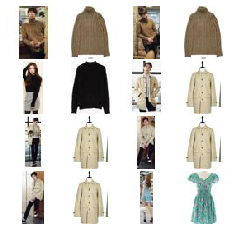

In [9]:
lookbook = Dataset(TRAIN_FOLDER, VAL_FOLDER, TEST_FOLDER)
X, y_assoc, y_not_assoc = next(lookbook.get_iter(16, 'train'))
show_images([tf.cast(X, tf.uint8), tf.cast(y_assoc, tf.uint8)])

In [10]:
def binary_crossentropy(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)  
    return tf.reduce_mean(bce(y_true, y_pred))

In [11]:
def real_fake_net_train_step(rf_net, real_images, generated_images):
    shape = (X.shape[0], 1)
    with tf.GradientTape() as tape:
        logits_real = real_fake_discrim(real_images, True)
        logits_fake = real_fake_discrim(generated_images, True)

        rf_loss = (binary_crossentropy(tf.ones(shape), logits_real) +
                   binary_crossentropy(tf.zeros(shape), logits_fake))
    gradients = tape.gradient(rf_loss, rf_net.trainable_variables)
    solver.apply_gradients(zip(gradients, rf_net.trainable_variables))
            
    return rf_loss

def domain_net_train_step(domain_net, X, domain_images, apply_grads=True):
    # X - source images
    # domain images tuple of (y_associated, y_not_associated, y_generated)
    shape = (X.shape[0], 1)
    logits_true, logits_fake = (tf.ones(shape), tf.zeros(shape))
    
    data = zip([X]*len(domain_images), domain_images, [logits_true, logits_fake, logits_fake])
    total_loss = 0.0
    with tf.GradientTape() as tape:
        for X, feed, y_true in data:
            y_pred = domain_net(tf.concat((X, feed), axis=3), apply_grads)
            total_loss += binary_crossentropy(y_true, y_pred)
        total_loss /= 3
    if apply_grads:
        gradients = tape.gradient(total_loss, domain_net.trainable_variables)
        solver.apply_gradients(zip(gradients, domain_net.trainable_variables))
    return total_loss

def converter_net_train_step(rf_net, domain_net, conv_net, X, domain_images):
    # X - source images
    # domain images tuple of (y_associated, y_not_associated)
    shape = (X.shape[0], 1)
    
    with tf.GradientTape() as tape:
        y_hat = conv_net(X, True)
        
        logits_fake = rf_net(y_hat, False)
        logits_real = tf.ones(shape)
        loss1 = binary_crossentropy(logits_real, logits_fake)
        
        loss2 = domain_net_train_step(domain_net, X, domain_images + y_hat, False)
        
        conv_loss = 0.5 * loss1 + 0.5 * loss2
                                
    gradients = tape.gradient(conv_loss, conv_net.trainable_variables)
    solver.apply_gradients(zip(gradients, conv_net.trainable_variables))
    return conv_loss

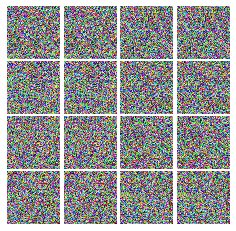

In [12]:
import cv2


def norm(images):
    for i, im in enumerate(images):
        images[i] = cv2.normalize(im, images[i], -1,  1 , cv2.NORM_MINMAX , cv2.CV_32FC3)
    return images

def denorm(images):
    for i, im in enumerate(images):
        images[i] = cv2.normalize(im, images[i], 0, 255, cv2.NORM_MINMAX, cv2.CV_32FC3)
    return images

n = denorm(sample_noise((16, 64, 64, 3)).numpy())
show_images([tf.cast(n, tf.uint8), tf.cast(n, tf.uint8)])

In [13]:
def get_current_iter(ckpt_path, save_freq):
    latest = tf.train.latest_checkpoint(ckpt_path)
    return int(latest.split('-')[-1]) * save_freq if latest else 0

Epoch 0. Iter 0. C: 0.4799317717552185, D_A: 0.810479462146759, D_R 1.4530787467956543


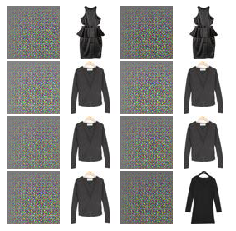

Epoch 0. Iter 0. Saving models...
Epoch 0. Iter 5. C: 0.4788992702960968, D_A: 0.8045000433921814, D_R 1.4356037378311157


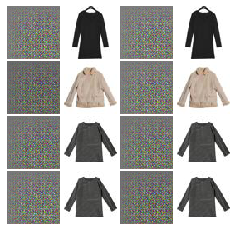

In [ ]:
from itertools import cycle


device = '/device:GPU:0'
BATCH_SIZE = 64
MOMENTUM = 0.5
n_epochs = 25
learning_rate = 0.0002
print_freq = 5 # print results every print_freq iterations
save_freq = 10 # save weights every save_freq iterations

with tf.device(device):
    lookbook = Dataset(TRAIN_FOLDER, VAL_FOLDER, TEST_FOLDER)
    val_iter = cycle(lookbook.get_iter(16, 'val'))
    solver = tf.keras.optimizers.SGD(learning_rate, MOMENTUM)
    
    real_fake_discrim = Discriminator(input_shape=(BATCH_SIZE, 64, 64, 3))
    domain_discrim = Discriminator(input_shape=(BATCH_SIZE, 64, 64, 3))
    converter = Converter(BATCH_SIZE)
    
    rf_ckpt = tf.train.Checkpoint(optimizer=solver, model=real_fake_discrim)
    rf_manager = tf.train.CheckpointManager(rf_ckpt, 
                                            directory="./models/real_fake_discriminator", 
                                            max_to_keep=3)
    status = rf_ckpt.restore(rf_manager.latest_checkpoint)
    
    dom_ckpt = tf.train.Checkpoint(optimizer=solver, model=domain_discrim)
    dom_manager = tf.train.CheckpointManager(dom_ckpt, 
                                             directory="./models/domain_discriminator", 
                                             max_to_keep=3)
    status = dom_ckpt.restore(dom_manager.latest_checkpoint)
    
    conv_ckpt = tf.train.Checkpoint(optimizer=solver, model=converter)
    conv_manager = tf.train.CheckpointManager(conv_ckpt, 
                                              directory="./models/converter", 
                                              max_to_keep=3)
    status = conv_ckpt.restore(conv_manager.latest_checkpoint)
    
    iter_cnt = get_current_iter('./models/converter', save_freq)
    for i in range(n_epochs):
        for batch in lookbook.get_iter(BATCH_SIZE, 'train'):
            X, y_assoc, y_not_assoc = [tf.constant(norm(data), dtype=tf.float32) for data in batch]
#             random_noise = sample_noise(X.shape)
            y_hat = converter(X, False)

            rf_loss = real_fake_net_train_step(real_fake_discrim, y_assoc, y_hat)
            domain_loss = domain_net_train_step(domain_discrim, X, (y_assoc, y_not_assoc, y_hat))
            conv_loss = converter_net_train_step(real_fake_discrim,
                                                domain_discrim,
                                                converter,
                                                X,
                                                (y_assoc, y_not_assoc))
                
            if iter_cnt % print_freq == 0:
                print(f'Epoch {i}. Iter {iter_cnt}. C: {conv_loss}, D_A: {domain_loss}, D_R {rf_loss}')
                X, y_assoc, _ = next(val_iter)
                y_hat = np.clip(denorm(converter(norm(X)).numpy()), 0, 255)
                show_images([tf.cast(y_hat, tf.uint8), tf.cast(y_assoc, tf.uint8)])
                plt.show()
            
            if iter_cnt % save_freq == 0:
                print(f'Epoch {i}. Iter {iter_cnt}. Saving models...')
                rf_manager.save()
                dom_manager.save()
                conv_manager.save()
            iter_cnt += 1
            
        if i % 20 == 0:
            solver = tf.keras.optimizers.SGD(learning_rate / 10, MOMENTUM)